In [1]:
import os
os.environ["HF_DATASETS_OFFLINE"]="1"
os.environ["HF_HUB_OFFLINE"]="1"
import os.path as osp

import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation, Mask2FormerModel, AutoModelForUniversalSegmentation
import accelerate


# load Mask2Former fine-tuned on Cityscapes semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-coco")
model = AutoModelForUniversalSegmentation.from_pretrained("/Data3/cao/ZiHanCao/exps/panformer/downstreams/segmentation/runs")
# accelerate.load_checkpoint_in_model(model, "/Data3/cao/ZiHanCao/exps/panformer/downstreams/segmentation/runs/step_2000/model.safetensors")
model = model.eval()


/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: FutureWarning: `max_size` is deprecated and removed starting from version 4.27.0 for `MaskFormerImageProcessor.__init__`.
  return func(*args, **kwargs)


In [26]:
test_on = 'all'
fused_dir = "/Data3/cao/ZiHanCao/exps/panformer/visualized_img/panRWKV_v3/msrs"
vi_dir = "/Data3/cao/ZiHanCao/datasets/MSRS/test/vi"
ir_dir = "/Data3/cao/ZiHanCao/datasets/MSRS/test/ir"
gt_dir = "/Data3/cao/ZiHanCao/datasets/MSRS/test/Segmentation_labels"
img_name = "01298N"


if test_on == 'fused':
    test_dir = {test_on: fused_dir}
elif test_on == 'vi':
    test_dir = {test_on: vi_dir}
elif test_on == 'ir':
    test_dir = {test_on: ir_dir}
elif test_on == 'all':
    test_dir = {
        'fused': fused_dir,
        'vi': vi_dir,
        'ir': ir_dir
    }
    
predicted_semantic_maps = {}
test_images = {}
for name, tst_d in test_dir.items():
    if name == 'fused':
        image_name = img_name + '.png'
    else:
        image_name = img_name + '.jpg'
    
    example_img = osp.join(tst_d, image_name)
    image = Image.open(example_img).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # model predicts class_queries_logits of shape `(batch_size, num_queries)`
    # and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits

    # you can pass them to processor for postprocessing
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    # we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
    
    predicted_semantic_maps.update({name: predicted_semantic_map})
    test_images.update({name: image})

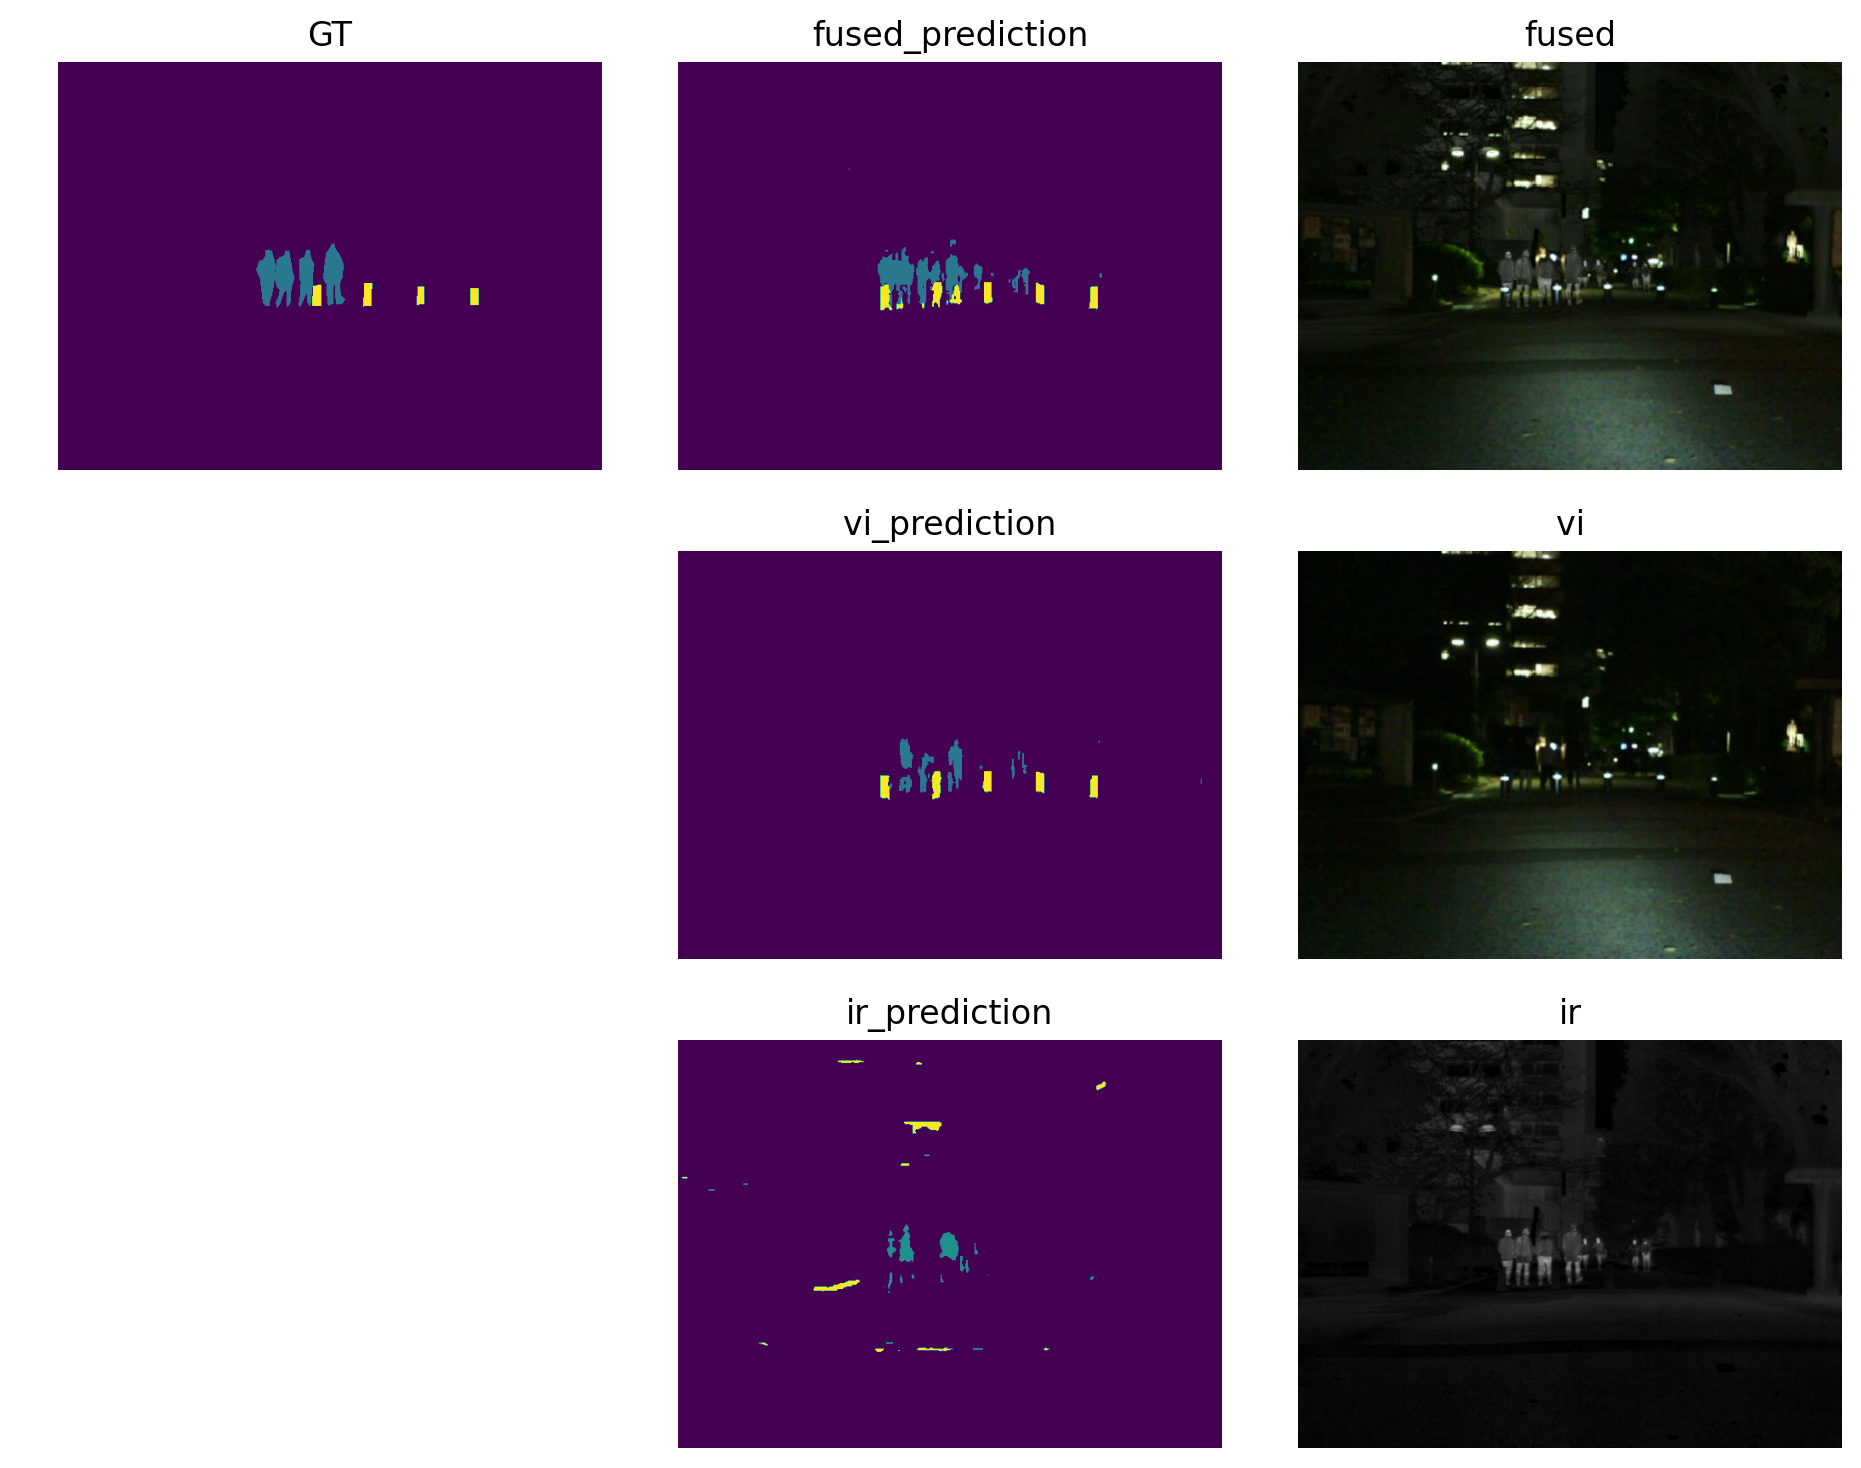

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# plots prediction maps
fig, axes = plt.subplots(len(predicted_semantic_maps), 3, figsize=(3*4, len(predicted_semantic_maps)*3), dpi=200)

for ax in axes.flatten():
    ax.axis("off")
    
plt.subplots_adjust(wspace=0, hspace=0.2)

# gt
gt = Image.open(osp.join(gt_dir, img_name + '.png'))
axes[0, 0].imshow(np.array(gt))
axes[0, 0].set_title('GT')

for i in range(len(predicted_semantic_maps)):
    axes[i, 1].imshow(predicted_semantic_maps[list(predicted_semantic_maps.keys())[i]].cpu().numpy())
    axes[i, 1].set_title(list(predicted_semantic_maps.keys())[i] + "_prediction")

    axes[i, 2].imshow(np.array(test_images[list(predicted_semantic_maps.keys())[i]]))
    axes[i, 2].set_title(list(predicted_semantic_maps.keys())[i])
    
# plt.tight_layout()
fig.savefig('/Data3/cao/ZiHanCao/exps/panformer/teasers/tesear-seg.png', dpi=200, bbox_inches='tight', pad_inches=0.1, transparent=True)

## load dataset from json file


In [2]:
from pathlib import Path
import datasets
from torch.utils.data import DataLoader

# create dataset
train_vi_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/train/vi')
train_ir_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/train/ir')
train_mask_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/train/Segmentation_labels')

test_vi_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/test/vi')
test_ir_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/test/ir')
test_mask_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/test/Segmentation_labels')

train_vi_files = list(train_vi_dir.glob('*.jpg'))
train_mask_files = list(train_mask_dir.glob('*.png'))

test_vi_files = list(test_vi_dir.glob('*.jpg'))
test_mask_files = list(test_mask_dir.glob('*.png'))


print('train files: ', len(train_vi_files), len(train_mask_files))
print('test files: ', len(test_vi_files), len(test_mask_files))

assert len(train_vi_files) == len(train_mask_files)
assert len(test_vi_files) == len(test_mask_files)

train_vi_files = [str(f) for f in train_vi_files]
train_mask_files = [str(f) for f in train_mask_files]

test_vi_files = [str(f) for f in test_vi_files]
test_mask_files = [str(f) for f in test_mask_files]


train files:  1083 1083
test files:  361 361


In [3]:
from datasets import Dataset, DatasetDict, Image
import albumentations as A


def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(train_vi_files, train_mask_files)
validation_dataset = create_dataset(test_vi_files, test_mask_files)

# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
  }
)



In [ ]:
dataset.push_to_hub('MSRS_seg', private=True,
                    data_dir='/Data3/cao/ZiHanCao/datasets/MSRS')

In [45]:
from torch.utils.data import DataLoader

dl=DataLoader(dataset['train'], batch_size=2, num_workers=4, shuffle=True)

In [46]:
next(iter(dl))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 154, in collate
    clone.update({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 191, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 161, in collate
    return {key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem}
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/torch/utils/data/_utils/collate.py", line 191, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>
